In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf 
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [5]:
select_number = [1, 3, 6, 9]
Number_Choice = len(select_number)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
Y_train_index =tf.reshape(tf.where([True if i in select_number else  False for i in y_train]), [-1])
x_train = x_train[Y_train_index,...]
y_train = y_train[Y_train_index]
Y_test_index = tf.reshape(tf.where([True if i in select_number else  False for i in y_test]), [-1])
x_test = x_test[Y_test_index,...]
y_test = y_test[Y_test_index,...]
print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(24740, 28, 28, 1) (24740,) (4112, 28, 28, 1) (4112,)


In [6]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation = 'relu'),
            layers.Dense(32, activation = 'relu'),
            layers.Dense(self.latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(32),
            layers.Dense(128, activation = 'relu'),
            layers.Dense(784, activation = 'sigmoid'),
            layers.Reshape((28, 28))
        ])
    
    def get_middle(self, x):
        return self.encoder(x)
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2),
      layers.Flatten(),
      layers.Dense(2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(392),
      layers.Reshape((7, 7, 8)),    
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [7]:
# autoencoder = Autoencoder(3)
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
774/774 [==============================] - 8s 10ms/step - loss: 0.0629 - val_loss: 0.0472
Epoch 2/5
774/774 [==============================] - 8s 10ms/step - loss: 0.0434 - val_loss: 0.0406
Epoch 3/5
774/774 [==============================] - 8s 10ms/step - loss: 0.0394 - val_loss: 0.0381
Epoch 4/5
774/774 [==============================] - 8s 10ms/step - loss: 0.0379 - val_loss: 0.0370
Epoch 5/5
774/774 [==============================] - 8s 10ms/step - loss: 0.0371 - val_loss: 0.0364


In [8]:
# print(autoencoder.encoder.summary())
# print(autoencoder.decoder.summary())
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(encoded_imgs.shape)

(4112, 2)


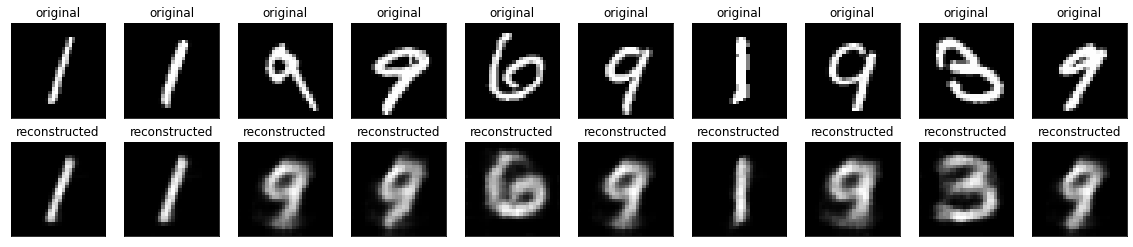

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
codeclass = {}
for ind_y in range(len(y_test)):
    if y_test[ind_y] not in codeclass:
        codeclass[y_test[ind_y]] = []
    codeclass[y_test[ind_y]].append(encoded_imgs[ind_y]) 

# print(encoded_imgs[0])
# print(encoder_middle.shape)

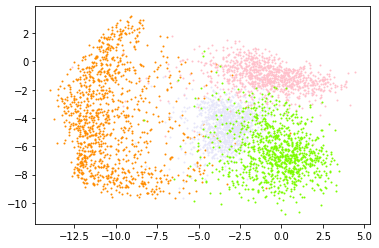

In [11]:
colors = ["black", "darkorange", "red", "lawngreen", "g", "sienna", "pink", "indigo", "lime", "lavender"]
plt.figure()
for i in codeclass:
    per_code = np.array(codeclass[i])
    plt.scatter(per_code[:,0], per_code[:,1], c=colors[i], s= 1)
plt.show()